<a href="https://colab.research.google.com/github/azaslight/Skin-Cancer-Classifier-modelathon/blob/main/area51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Установка и настройка Kaggle API
!pip install -q kaggle

# Создание папки для ключа и копирование файла
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Загрузка датасета Skin Cancer MNIST
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Распаковка архива
!unzip skin-cancer-mnist-ham10000.zip -d skin_cancer_data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: skin_cancer_data/ham10000_images_part_2/ISIC_0029337.jp

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [ ]:
# Просмотр содержимого папки
data_path = 'skin_cancer_data'
os.listdir(data_path)

['ham10000_images_part_2',
 'hmnist_8_8_RGB.csv',
 'hmnist_28_28_L.csv',
 'HAM10000_images_part_2',
 'hmnist_8_8_L.csv',
 'ham10000_images_part_1',
 'HAM10000_images_part_1',
 'HAM10000_metadata.csv',
 'hmnist_28_28_RGB.csv']

In [ ]:
# Загрузка метаданных
metadata_path = os.path.join(data_path, 'HAM10000_metadata.csv')
df = pd.read_csv(metadata_path)

# Просмотр первых строк таблицы
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [ ]:
# Информация о столбцах и их типах
print(df.info())

# Проверка количества записей и распределения по классам
print(df['dx'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


<ipython-input-6-c8a369a2a437>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dx', data=df, palette='viridis')


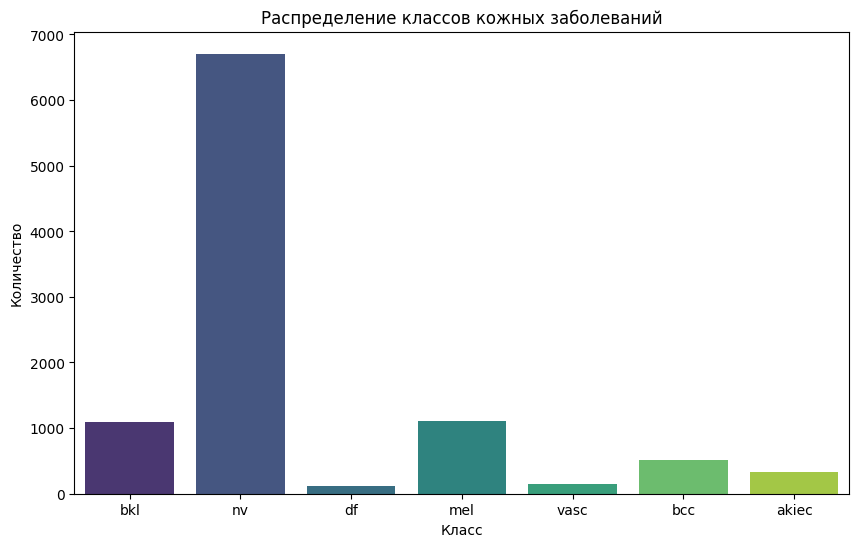

In [ ]:
# Визуализация распределения классов
plt.figure(figsize=(10, 6))
sns.countplot(x='dx', data=df, palette='viridis')
plt.title('Распределение классов кожных заболеваний')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

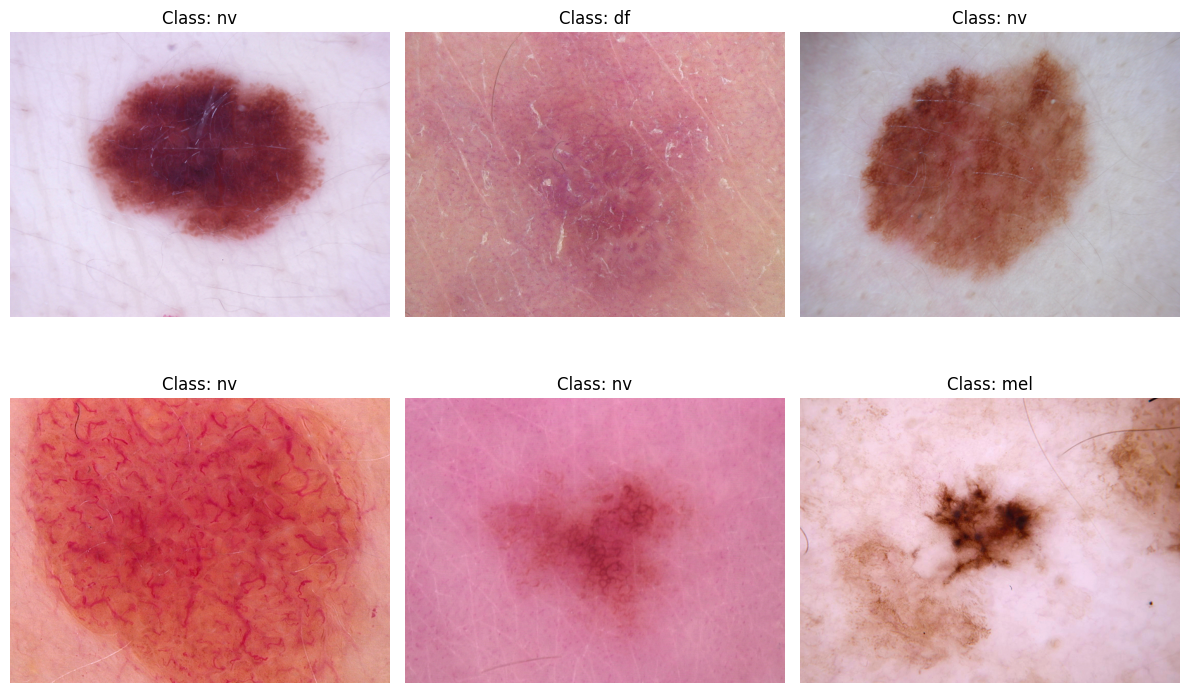

In [ ]:
# Пути к изображениям
image_folder_1 = os.path.join(data_path, 'HAM10000_images_part_1')
image_folder_2 = os.path.join(data_path, 'HAM10000_images_part_2')

# Функция для загрузки изображения по его имени
def load_image(img_id):
    img_path_1 = os.path.join(image_folder_1, img_id + '.jpg')
    img_path_2 = os.path.join(image_folder_2, img_id + '.jpg')
    if os.path.exists(img_path_1):
        return load_img(img_path_1)
    else:
        return load_img(img_path_2)

# Просмотр нескольких изображений
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
sample_images = df.sample(6)
for i, img_id in enumerate(sample_images['image_id']):
    img = load_image(img_id)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"Class: {sample_images.iloc[i]['dx']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

# Задаем размер изображений
IMG_SIZE = 64

# Функция для загрузки и обработки изображений
def preprocess_images(df, img_size):
    images = []
    labels = []

    for index, row in df.iterrows():
        img = load_image(row['image_id'])
        img = img.resize((img_size, img_size))
        img_array = img_to_array(img) / 255.0  # нормализация
        images.append(img_array)
        labels.append(row['dx'])

    return np.array(images), np.array(labels)

# Загрузка и предобработка изображений
X, y = preprocess_images(df, IMG_SIZE)

# Просмотр формы данных
print(f"Форма массива изображений: {X.shape}")
print(f"Форма массива меток: {y.shape}")

Форма массива изображений: (10015, 64, 64, 3)
Форма массива меток: (10015,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Кодирование меток классов
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Преобразование меток в one-hot формат
y_categorical = to_categorical(y_encoded)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

print(f"Размер обучающей выборки: {X_train.shape}, {y_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}, {y_test.shape}")

Размер обучающей выборки: (8012, 64, 64, 3), (8012, 7)
Размер тестовой выборки: (2003, 64, 64, 3), (2003, 7)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Создание модели
model = Sequential()

# Сверточный слой + MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Сглаживание
model.add(Flatten())

# Полносвязные слои
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout для предотвращения переобучения
model.add(Dense(len(df['dx'].unique()), activation='softmax'))  # Количество классов в выходном слое

# Компиляция модели
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Сводка модели
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,103 (2.61 MB)

 Trainable params: 684,103 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 62s 240ms/step - accuracy: 0.6573 - loss: 1.1214 - val_accuracy: 0.6690 - val_loss: 0.9458
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 243ms/step - accuracy: 0.6772 - loss: 0.9419 - val_accuracy: 0.6785 - val_loss: 0.8919
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 86s 258ms/step - accuracy: 0.6726 - loss: 0.9317 - val_accuracy: 0.6870 - val_loss: 0.8460
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 238ms/step - accuracy: 0.6729 - loss: 0.8609 - val_accuracy: 0.6905 - val_loss: 0.8276
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - accuracy: 0.6959 - loss: 0.8238 - val_accuracy: 0.6970 - val_loss: 0.8042
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 59s 237ms/step - accuracy: 0.6968 - loss: 0.8117 - val_accuracy: 0.7019 - val_loss: 0.7981
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 243ms/step - accuracy: 0.7080 - loss: 0.7745 - val_accuracy: 0.7084 - val_loss: 0.7589
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 61s 244ms/step - accuracy: 0.7214 - loss: 0

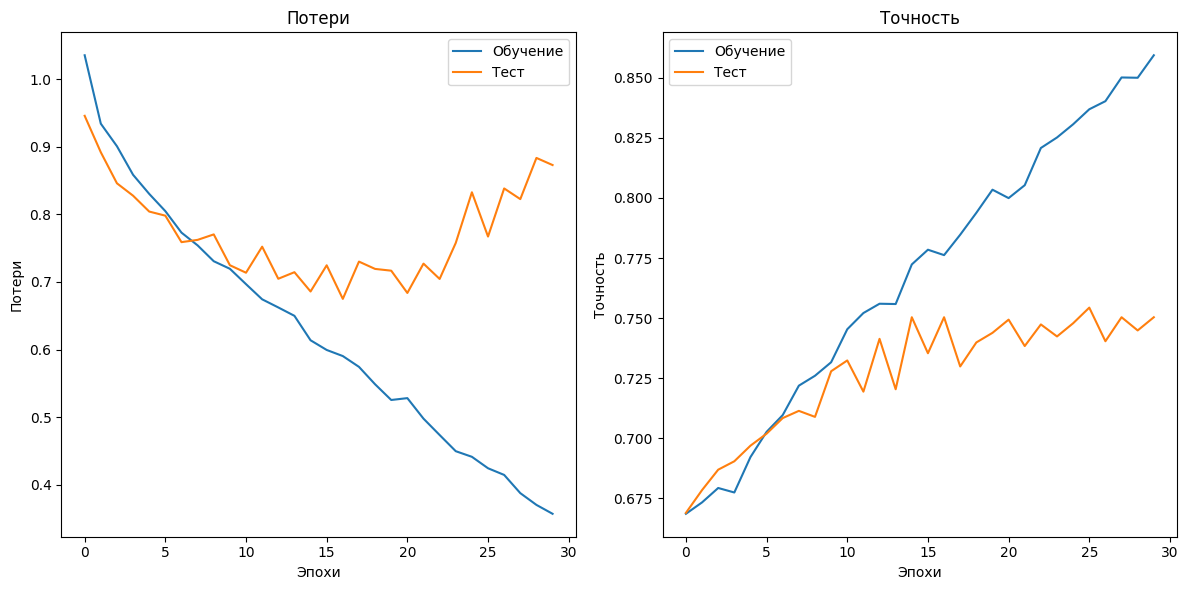

In [ ]:
# Визуализация потерь и точности
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Тест')
plt.title('Потери')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Обучение')
plt.plot(history.history['val_accuracy'], label='Тест')
plt.title('Точность')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Оценка модели
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Точность на тестовых данных: {test_accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.7485 - loss: 0.8484
Точность на тестовых данных: 75.04%


In [ ]:
# Сохранение модели
model.save('skin_cancer_classifier.h5')
print("Модель сохранена как 'skin_cancer_classifier.h5'")

Модель сохранена как 'skin_cancer_classifier.h5'


In [ ]:
import joblib

# Сохранение label_encoder
joblib.dump(label_encoder, 'label_encoder.pkl')
print("label_encoder сохранен как 'label_encoder.pkl'")

label_encoder сохранен как 'label_encoder.pkl'


In [ ]:
from google.colab import files

files.download('label_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>